In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from matplotlib import pyplot as plt
from sklearn.model_selection import GroupShuffleSplit
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.tree import DecisionTreeRegressor
import seaborn as sns
from utils import get_data_per_anchor, spatial_plot
from sklearn.linear_model import LinearRegression
import xgboost as xgb
import os
import warnings
from micromlgen import port
import m2cgen as m2c
from matplotlib import pyplot as plt
from matplotlib import colors
warnings.filterwarnings("ignore")

In [2]:
# torch.manual_seed(42)
np.random.seed(42)

In [3]:
params = {
    "test_size":0.33,
    "random_state":42,
    "splits":3,
    
}

In [4]:
df = pd.read_pickle("raw_IQ.pkl")
df.sort_values(['point', 'anchor', 'room', 'channel'], inplace=True)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [5]:
def iq_processing(data):
    
    """
    Input: Data
    Output: Processed Data

    Processing: Power Scaling, IQ shifting
    """

    cols_real = ['pdda_input_real_{}'.format(x+1) for x in range(5)]
    cols_imag = ['pdda_input_imag_{}'.format(x+1) for x in range(5)]

    iq_values = pd.DataFrame(data['pdda_input_real'].tolist(), columns=cols_real, index=data.index)
    iq_values[cols_imag] = pd.DataFrame(data['pdda_input_imag'].tolist(), columns=cols_imag, index=data.index)
    
    phase = pd.DataFrame(np.arctan2(iq_values['pdda_input_imag_1'],iq_values['pdda_input_real_1']), columns=['phase_1'])
    
    cos = np.cos(phase).values.ravel()
    sin = np.sin(phase).values.ravel()
    
    out = data.copy()
    iq_ref = np.abs(iq_values[f'pdda_input_real_1']*cos + iq_values[f'pdda_input_imag_1']*sin)
    for i in range(1,6):
        out[f'pdda_input_real_{i}'] = (iq_values[f'pdda_input_real_{i}']*cos + iq_values[f'pdda_input_imag_{i}']*sin)
        out[f'pdda_input_imag_{i}'] = (-iq_values[f'pdda_input_real_{i}']*sin + iq_values[f'pdda_input_imag_{i}']*cos)
        iq_ref +=  iq_values[f'pdda_input_real_{i}']**2 + iq_values[f'pdda_input_imag_{i}']**2

    power_norm =  StandardScaler().fit_transform((out['reference_power'] + out['relative_power']).values.reshape(-1,1))/10
    
    out.insert(25, 'power', power_norm)
    out.insert(24, 'iq_ref', iq_ref)
    out.drop(columns=['pdda_input_imag_1', 'pdda_input_real', 'pdda_input_imag'], inplace=True)
    return out

In [6]:
features = ['power', 'pdda_input_real_1', 'pdda_input_real_2', 'pdda_input_imag_2', 'pdda_input_real_3', 'pdda_input_imag_3', 'pdda_input_real_4', 'pdda_input_imag_4',
           'pdda_input_real_5', 'pdda_input_imag_5']
# theta does not change, make predictions for phi only, azimuth angles 
# predict only for phi, 
targets = ['true_phi']
location = ['x_tag', 'y_tag']
pdda_angle = ['pdda_phi']
point = ['point']

In [7]:
def scale(df):
    """scale dataset with mean=0, std=1"""
    scaler = StandardScaler()
    df[features] = scaler.fit_transform(df[features])
    return df

In [8]:
def select_polarity(df):
    """"rssi signals closer to 0, represent the better quality of signal"""
    tmp = df.sort_values(['point', 'anchor', 'channel', 'room'])
    tmp['mask'] = tmp['reference_power'] + df['relative_power']
    tmp = tmp.sort_values(['point', 'anchor', 'channel', 'room', 'mask'])
    tmp = tmp.drop_duplicates(subset=['point', 'anchor', 'channel', 'room'], keep='last')
    return tmp

In [9]:
def select_random_channel(df):
    mid_concrete_random = pd.DataFrame()
    for room in df.room.unique():
        room_df = df.loc[df['room'] == room]
        for anchor in df.anchor.unique():
            anchor_df = room_df.loc[room_df['anchor'] == anchor]
            grouped = anchor_df.groupby(['point'],as_index=False)
            for group, tdf in grouped:
                random_selection = tdf.sample(n=1,random_state=42)
                mid_concrete_random = pd.concat([mid_concrete_random, random_selection])
    return mid_concrete_random

In [10]:
# mid_concrete.head()

In [11]:
def train(df, df_test, models, metrics):
    results = pd.DataFrame()
    true_phi = []
    model_preds = []
    pdda_preds = []
    x_loc = []
    y_loc = []
    anchor_val = []
    pts = []
    m_preds = {}
    flag = True
    trained_models = {}
    for model in models:
        print(str(model))
        for anchor in [4.0]:
            temp = pd.DataFrame()
            anchor_df = df.loc[df['anchor'] == anchor]
            anchor_test_df = df_test.loc[df_test['anchor'] == anchor]
            X = anchor_df[new_features].values
            y = anchor_df[targets].values
            X_train = X
            y_train = y
            X_test = anchor_test_df[new_features].values
            y_test = anchor_test_df[targets].values
            
            test_location = anchor_test_df[location].values
            pdda_result = anchor_test_df[pdda_angle].values
            points = anchor_test_df[point].values

            # learn the trainer on the train set and apply for testing set
            regr = model
            regr.fit(X_train,y_train)
            if str(model) not in trained_models:
                if str(model).split("(")[0] != "XGBRegressor":
                    trained_models[str(model)] = regr
                else:
                    trained_models["XGBRegressor"] = regr
            # trained_models.append(regr)
            predictions = regr.predict(X_test)
            # need pointwise error for plotting using spatial_plot function
            # errors = []
            avg_mae = []
            # print(len(predictions))
            # print(pdda_result.shape)
            # temp = []
            for i in range(len(predictions)):
                model_preds.append(predictions[i])
                # predictions.append(mean_absolute_error(y_test[i], temp))
                pdda_preds.append(pdda_result[i][0])
                true_phi.append(y_test[i][0])
                x_coordinate, y_coordinate = test_location[i]
                pts.append(points[i][0])
                x_loc.append(x_coordinate)
                y_loc.append(y_coordinate)
                anchor_val.append(anchor)
        # print(pdda_preds)
        if flag:
            temp['pdda'] = pdda_preds
            temp['true_phi'] = true_phi
            temp['x_loc'] = x_loc
            temp['y_loc'] = y_loc
            temp['point'] = pts
            temp['anchor'] = anchor_val
            results = pd.concat([results, temp])
            flag = False
            
        model_name = str(model).split("(")[0]
        if model_name != 'XGBRegressor':
            model_name = str(model)
        m_preds[model_name] = model_preds
        model_preds = []
        pdda_preds = []
        true_phi = []
        x_loc = []
        y_loc = []
        pts = []
        anchor_val = []
        # results = pd.concat([results, temp])
    for k,v in m_preds.items():
        results[k] = v
        
    return (results, trained_models)

In [12]:
new_features = ['power_37', 'pdda_input_real_1_37', 'pdda_input_real_2_37', 'pdda_input_imag_2_37', 'pdda_input_real_3_37', 'pdda_input_imag_3_37', 'pdda_input_real_4_37', 'pdda_input_imag_4_37',
               'pdda_input_real_5_37', 'pdda_input_imag_5_37','power_38', 'pdda_input_real_1_38', 'pdda_input_real_2_38', 'pdda_input_imag_2_38', 'pdda_input_real_3_38', 'pdda_input_imag_3_38',
                        'pdda_input_real_4_38', 'pdda_input_imag_4_38','pdda_input_real_5_38', 'pdda_input_imag_5_38',
                       'power_39', 'pdda_input_real_1_39', 'pdda_input_real_2_39', 'pdda_input_imag_2_39', 'pdda_input_real_3_39', 'pdda_input_imag_3_39',
                        'pdda_input_real_4_39', 'pdda_input_imag_4_39','pdda_input_real_5_39', 'pdda_input_imag_5_39']

In [13]:
models = [RandomForestRegressor(), RandomForestRegressor(n_estimators=10),   
          DecisionTreeRegressor(),  KNeighborsRegressor(), MLPRegressor(), SVR(), GradientBoostingRegressor(),xgb.XGBRegressor(),LinearRegression()]
metrics = [mean_absolute_error, r2_score]

In [14]:
# cols = ['element1','element2','element3','element4','element5']

def combine_features(df):
    grouped = df.groupby(['room','anchor', 'point'],as_index=False)
    new_features = ['power_37', 'pdda_input_real_1_37', 'pdda_input_real_2_37', 'pdda_input_imag_2_37', 'pdda_input_real_3_37', 'pdda_input_imag_3_37', 'pdda_input_real_4_37', 'pdda_input_imag_4_37',
               'pdda_input_real_5_37', 'pdda_input_imag_5_37','power_38', 'pdda_input_real_1_38', 'pdda_input_real_2_38', 'pdda_input_imag_2_38', 'pdda_input_real_3_38', 'pdda_input_imag_3_38',
                        'pdda_input_real_4_38', 'pdda_input_imag_4_38','pdda_input_real_5_38', 'pdda_input_imag_5_38',
                       'power_39', 'pdda_input_real_1_39', 'pdda_input_real_2_39', 'pdda_input_imag_2_39', 'pdda_input_real_3_39', 'pdda_input_imag_3_39',
                        'pdda_input_real_4_39', 'pdda_input_imag_4_39','pdda_input_real_5_39', 'pdda_input_imag_5_39']
    x_loc = []
    y_loc = []
    pts = []
    pdda = []
    anchors = []
    pdda = []
    true_phi = []
    room = []
    combined_features = []
    temp = pd.DataFrame()
    for group, tdf in grouped:
        soi_matrix = tdf[features]
        # print(soi_matrix)
        soi_matrix = soi_matrix.values.reshape(1,30)
        # print(soi_matrix[0])
        # break
        x_loc.append(tdf['x_tag'].values[0])
        y_loc.append(tdf['y_tag'].values[0])
        pts.append(tdf['point'].values[0])
        anchors.append(tdf['anchor'].values[0])
        pdda.append(tdf['pdda_phi'].values[0])
        room.append(tdf['room'].values[0])
        combined_features.append(soi_matrix[0])
        true_phi.append(tdf['true_phi'].values[0])

    temp[new_features] = combined_features
    temp['true_phi'] = true_phi
    temp['pdda_phi'] = pdda
    temp['anchor'] = anchors
    temp['point'] = pts
    temp['x_tag'] = x_loc
    temp['y_tag'] = y_loc
    temp['room'] = room
    return temp

In [15]:
no_f = df[df['room'] == 'testbench_01']
no_f = iq_processing(no_f)
no_f = scale(no_f)
no_f = select_polarity(no_f)
# no_f = select_random_channel(no_f)
no_f = combine_features(no_f)


In [16]:
low = df[df['room'] == 'testbench_01_furniture_low']
low = iq_processing(low)
low = scale(low)
low = select_polarity(low)
# low = select_random_channel(low)
low = combine_features(low)

In [17]:
mid = df[df['room'] == 'testbench_01_furniture_mid']
mid = iq_processing(mid)
mid = scale(mid)
mid = select_polarity(mid)
# mid = select_random_channel(mid)
mid = combine_features(mid)

In [18]:
high = df[df['room'] == 'testbench_01_furniture_high']
high = iq_processing(high)
high = scale(high)
high = select_polarity(high)
# high = select_random_channel(high)
high = combine_features(high)

In [19]:
# results, trained_models = train(high, mid, models, metrics)

In [20]:
def calculate_mae_errors(results):
    # calculate average mae errors over all anchors
    grouped = results.groupby(['point','anchor'],as_index=False)
    avg_errors = pd.DataFrame()

    for group, tdf in grouped:
        p_df = pd.DataFrame()
        maes_pdda = []
        maes_rf100 = []
        maes_rf10 = []
        maes_svr = []
        rf = []
        maes_lr = []
        true = []
        maes_xgboost = []
        maes_dt = []
        x_locs = []
        y_locs = []
        # print(tdf['true_phi'].values[0])
        maes_pdda.append(mean_absolute_error([np.mean(tdf['pdda'].values)], [tdf['true_phi'].values[0]]))
        true.append(tdf['true_phi'].values[0])
        maes_rf100.append(mean_absolute_error([np.mean(tdf['RandomForestRegressor()'].values)], [tdf['true_phi'].values[0]]))
        maes_rf10.append(mean_absolute_error([np.mean(tdf['RandomForestRegressor(n_estimators=10)'].values)], [tdf['true_phi'].values[0]]))
        maes_svr.append(mean_absolute_error([np.mean(tdf['SVR()'].values)], [tdf['true_phi'].values[0]]))
        maes_xgboost.append(mean_absolute_error([np.mean(tdf['XGBRegressor'].values)], [tdf['true_phi'].values[0]]))
        maes_dt.append(mean_absolute_error(tdf['DecisionTreeRegressor()'].values, tdf['true_phi'].values))
        maes_lr.append(mean_absolute_error([np.mean(tdf['LinearRegression()'].values)], [tdf['true_phi'].values[0]]))
        x_locs.append(tdf['x_loc'].values[0])
        y_locs.append(tdf['y_loc'].values[0])
        # rf.append([np.mean(tdf['RandomForestRegressor()'].values)])
        p_df['MAE_pdda'] = maes_pdda
        p_df['MAE_LR'] = maes_lr
        p_df['MAE_SVR'] = maes_svr
        p_df['MAE_DT'] = maes_dt
        
        p_df['MAE_RF10'] = maes_rf10
        
        p_df['MAE_XGBoost'] = maes_xgboost

        p_df['MAE_RF100'] = maes_rf100
        p_df['x_loc'] = x_locs
        p_df['y_loc'] = y_locs
        p_df['true'] = true
        # p_df['rf'] = rf
        avg_errors = pd.concat([avg_errors, p_df])
    return avg_errors
            


In [72]:
mean_absolute_error([np.mean(np.asarray([3,0]))],[1])

0.5

In [71]:
mean_absolute_error([3,0],[1,1])

1.5

In [32]:
errors = calculate_mae_errors(results)

KeyboardInterrupt: 

In [302]:
errors.head()

,MAE_pdda,MAE_LR,MAE_SVR,MAE_DT,MAE_RF10,MAE_XGBoost,MAE_RF100,x_loc,y_loc,true,rf
0,5.4,16.759854,14.394249,11.1,12.10,8.715351,11.086,44.1,43.3,45.0,[33.913999999999994]
0,0.6,0.162543,2.395431,1.3,1.79,2.436295,1.044,44.1,43.3,-19.1,[-20.143999999999995]
0,4.3,26.683631,34.234842,1.7,6.46,2.604846,4.369,44.1,43.3,-46.7,[-42.33099999999999]
0,225.0,92.773262,137.462421,108.4,96.05,74.239906,85.228,44.1,43.3,135.0,[49.772000000000006]
0,2.0,19.073501,12.836766,0.2,2.27,6.455901,1.495,44.1,43.5,44.2,[42.705]


In [34]:
transfer = pd.DataFrame()

In [105]:
individual = pd.read_pickle('results/figure3_panel1.pkl')


In [116]:
list(individual.loc['XGBoost'])

[5.643570582611453, 5.838038035708714, 6.218492374651662, 6.293050081375781]

In [189]:
individual.head(20)

,testbench_01,testbench_01_furniture_low,testbench_01_furniture_mid,testbench_01_furniture_high
pdda,8.543385,8.432292,9.389305,8.860607
Linear Regression,9.412078,9.568003,9.844010,10.268760
SVR,8.547875,8.643641,8.761621,9.003906
Decision Tree,6.882543,7.261287,7.606070,7.617472
RF10,5.611666,5.740991,6.253664,6.183317
XGBoost,5.643571,5.838038,6.218492,6.293050
RF100,5.413609,5.568117,5.972842,5.890732
aoanet,4.831005,4.991831,5.408162,5.551577


In [114]:
models_names = ['MAE_pdda','MAE_RF','MAE_XGBoost', 'MAE_DT']
res = {}
room = ['No Furniture', 'Low Furniture', 'Mid Furniture','High Furniture']
models = [DecisionTreeRegressor()]
individual = pd.read_pickle('results/multichannel.pkl')
for i in range(len(room)):
    for j in range(len(room)):
        if i==j:
            if room[i] == 'No Furniture':
                mae = individual.loc['Decision Tree', 'testbench_01']
            elif room[i] == 'Low Furniture':
                mae = individual.loc['Decision Tree', 'testbench_01_furniture_low']
            elif room[i] == 'Mid Furniture':
                mae = individual.loc['Decision Tree', 'testbench_01_furniture_mid']
            else:
                mae = individual.loc['Decision Tree', 'testbench_01_furniture_high'] 
            if room[i] not in res:
                res[room[i]] = [mae]
            else:
                res[room[i]].append(mae)
            continue
            
        if room[i] == 'No Furniture':
            train_room = no_f
        elif room[i] == 'Low Furniture':
            train_room = low
        elif room[i] == 'Mid Furniture':
            train_room = mid
        elif room[i] == 'High Furniture':
            train_room = high
            
        if room[j] == 'No Furniture':
            test_room = no_f
        elif room[j] == 'Low Furniture':
            test_room = low
        elif room[j] == 'Mid Furniture':
            test_room = mid
        elif room[j] == 'High Furniture':
            test_room = high
            
        
        results, trained_models = train(train_room, test_room, models, metrics)
        # print(results)
        errors = calculate_mae_errors(results)
        # print(errors)
        mae_error = np.mean(errors['MAE_DT'].values) 
        if room[i] not in res:
            res[room[i]] = [mae_error]
        else:
             res[room[i]].append(mae_error)
                
        
        
        


DecisionTreeRegressor()


KeyError: 'RandomForestRegressor()'

In [87]:
transfer = pd.DataFrame.from_dict(res, orient='index')
transfer.columns = ['No Furniture', 'Low Furniture', 'Mid Furniture','High Furniture']

In [89]:
transfer.head()

,No Furniture,Low Furniture,Mid Furniture,High Furniture
No Furniture,5.853511,3.696925,6.086780,6.888282
Low Furniture,3.660748,6.228757,5.174704,6.428647
Mid Furniture,5.249602,4.703617,6.700604,5.343942
High Furniture,6.849295,6.277278,5.353974,6.338072


In [60]:
pdda_df = pd.DataFrame()
pdda_df['pdda'] = list(individual.loc['pdda'])
pdda_df.rename(columns = {0: ''}, inplace = True)

In [61]:
pdda_df.head()

,pdda
0,8.543385
1,8.432292
2,9.389305
3,8.860607


In [54]:
pdda_df['pdda'].values.reshape(4,1).T

array([[8.54338539, 8.43229228, 9.38930466, 8.86060695]])

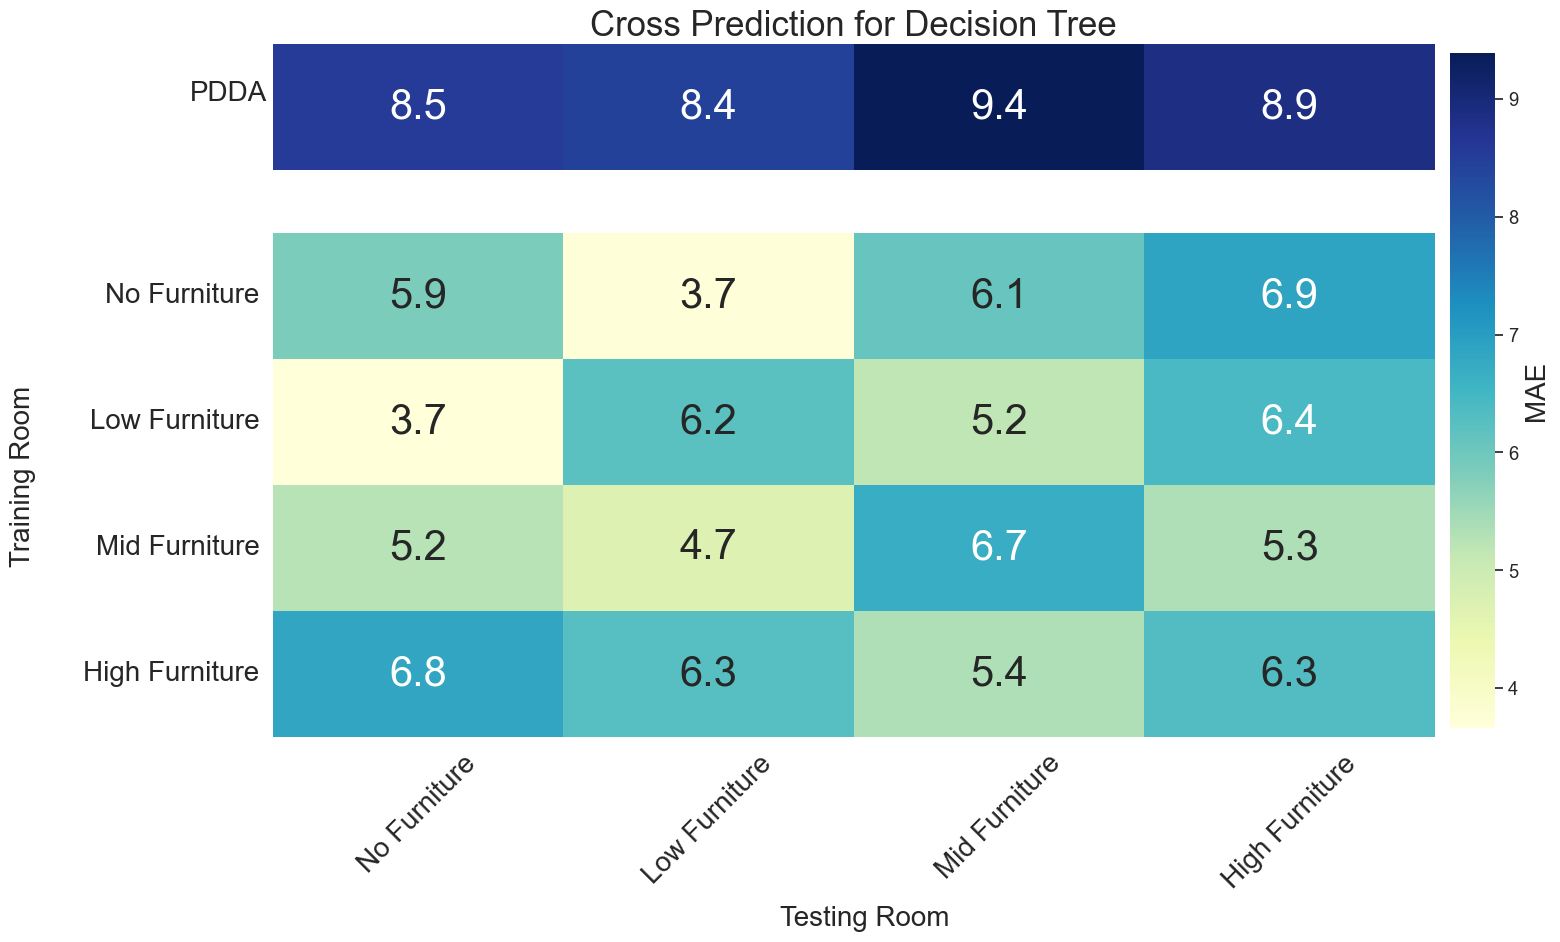

In [90]:

fig, ax = plt.subplots(2,1, sharex=True, figsize=(15,9), gridspec_kw={'height_ratios': [1,4]})
cbar_ax = fig.add_axes([.91, .12, .03, .75])
vmax = np.max(pdda_df)
vmin = np.min(transfer.values)
sns.heatmap(pdda_df['pdda'].values.reshape(4,1).T,annot=True, annot_kws={"size": 30}, cmap="YlGnBu", vmax = vmax, vmin = vmin, cbar_ax = cbar_ax,ax=ax[0], xticklabels=False, yticklabels=False)
sns.heatmap(transfer, annot=True, annot_kws={"size": 30}, cbar=False, vmax = vmax, vmin = vmin, cmap="YlGnBu", cbar_ax = None, ax=ax[1])
ax[0].set_ylabel('PDDA', rotation=0, ha='right', fontsize=20)
sns.set(font_scale=1.2)
fig.text(0.52, -0.1, 'Testing Room', ha='center', fontsize=20)
fig.text(-0.05, 0.4, 'Training Room', va='center', rotation='vertical',fontsize=20)
cbar_ax.set_ylabel('MAE', fontsize=20)

ax[1].set_yticklabels(ax[1].get_yticklabels(), rotation=0,fontsize=20) 
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=45, ha='center', fontsize=20) 
ax[0].set_title('Cross Prediction for Decision Tree',fontsize=25)
plt.savefig('figures/Figure4/multichannel/dt',bbox_inches='tight')
plt.savefig('figures/Figure4/multichannel/dt.pdf', bbox_inches='tight')
plt.show()

In [22]:
#figure4 panel 2
no_f = no_f[no_f['anchor'] == 4]
high = high[high['anchor'] == 4]
models = [RandomForestRegressor(), RandomForestRegressor(n_estimators=10),   
          DecisionTreeRegressor(),  KNeighborsRegressor(), MLPRegressor(), SVR(), GradientBoostingRegressor(),xgb.XGBRegressor(),LinearRegression()]

results, trained_models = train(no_f, high, models, metrics)
# print(results)
results['pdda'][results.iloc[:,0] > 50 ] = 50
results['pdda'][results.iloc[:,0] < -50 ] = -50
errors = calculate_mae_errors(results)



RandomForestRegressor()
RandomForestRegressor(n_estimators=10)
DecisionTreeRegressor()
KNeighborsRegressor()
MLPRegressor()
SVR()
GradientBoostingRegressor()
XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...)
LinearRegression()


In [23]:
results.head()

,pdda,true_phi,x_loc,y_loc,point,anchor,RandomForestRegressor(),RandomForestRegressor(n_estimators=10),DecisionTreeRegressor(),KNeighborsRegressor(),MLPRegressor(),SVR(),GradientBoostingRegressor(),XGBRegressor,LinearRegression()
0,-50.0,135.0,44.1,43.3,2,4.0,73.230,82.29,135.0,[59.32000000000001],110.749882,-2.498210,73.773114,84.337631,[17.940694689119088]
1,34.7,90.0,44.1,43.5,3,4.0,30.708,29.47,11.3,[75.75999999999999],104.956437,-2.418568,34.063496,40.286491,[26.730628597244994]
2,4.0,71.6,44.1,43.7,4,4.0,22.263,17.79,14.7,[5.959999999999999],30.737734,-2.597598,40.940155,30.817085,[-2.8964698399101074]
3,-28.3,63.4,44.1,43.9,5,4.0,-10.374,-21.21,-17.4,[-8.38],15.719512,-5.402173,24.277584,27.939028,[-27.3601484461126]
4,28.3,59.0,44.1,44.1,6,4.0,28.624,25.23,59.0,[32.660000000000004],53.935251,-0.879064,31.835403,39.484158,[23.35556975909907]


In [24]:
list(errors)

['MAE_pdda',
 'MAE_LR',
 'MAE_SVR',
 'MAE_DT',
 'MAE_RF10',
 'MAE_XGBoost',
 'MAE_RF100',
 'x_loc',
 'y_loc',
 'true']

In [25]:

# spatial_plot(errors['MAE_DT'], errors['x_loc'], errors['y_loc'], 'figures/Figure4/single/train_no_test_high_dt', 'MAE scores for Decision Tree', testing_room='testbench_01_furniture_high_concrete', vmax=10, anchors=[4])


In [167]:
errors.head()

,MAE_pdda,MAE_LR,MAE_SVR,MAE_DT,MAE_RF10,MAE_XGBoost,MAE_RF100,x_loc,y_loc,true,xgboost_diff
0,185.0,117.059305,137.498210,0.0,38.32,50.662369,68.082,44.1,43.3,135.0,134.337631
0,55.3,63.269371,92.418568,79.4,43.57,49.713509,55.170,44.1,43.5,90.0,5.586491
0,67.6,74.496470,74.197598,56.9,53.50,40.782915,53.586,44.1,43.7,71.6,26.817085
0,91.7,90.760148,68.802173,80.8,68.99,35.460972,76.165,44.1,43.9,63.4,56.239028
0,30.7,35.644430,59.879064,0.0,31.20,19.515842,31.981,44.1,44.1,59.0,11.184158


In [41]:
errors['diff'] = errors.apply(lambda row: row['MAE_pdda']- row['MAE_RF100'], axis=1, result_type='expand')

In [48]:
neg = errors['diff'] < -5
pos = errors['diff'] > 5

In [49]:
neg.value_counts()

False    2225
True      222
Name: diff, dtype: int64

In [50]:
pos.value_counts()

False    1820
True      627
Name: diff, dtype: int64

In [45]:
1791+656

2447

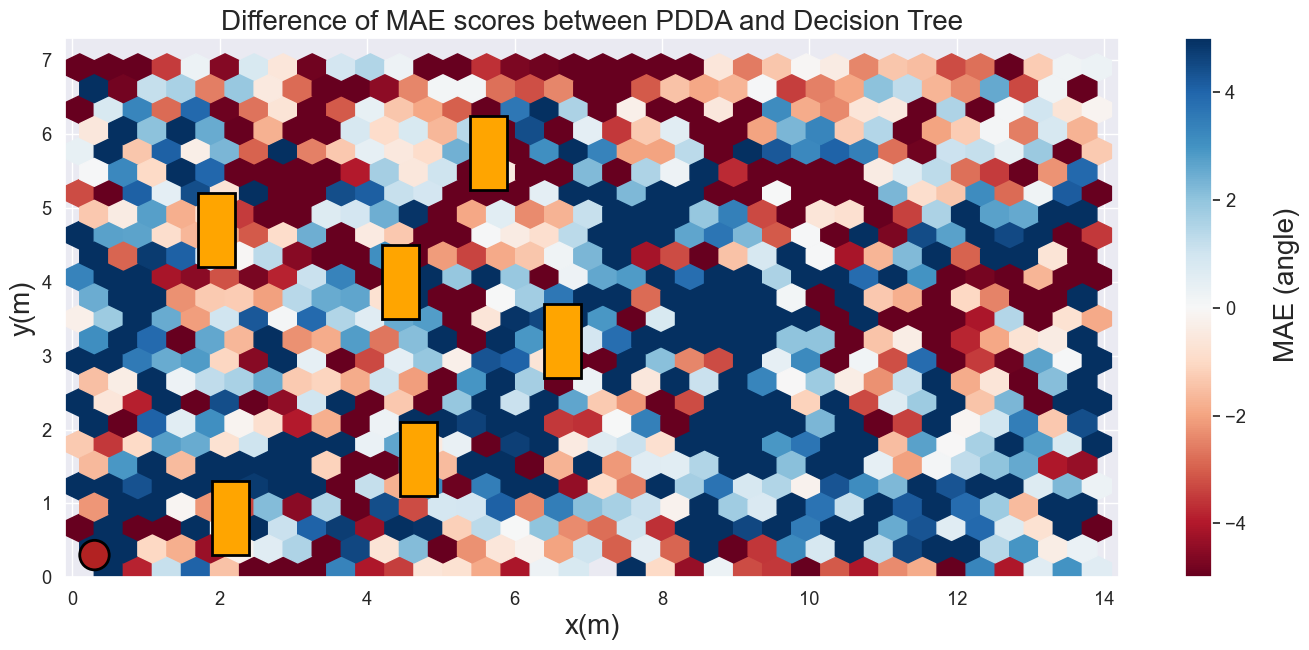

In [192]:
# spatial_plot(errors['dt_diff'], errors['x_loc'], errors['y_loc'], 'figures/Figure4/panel2/diff_pdda_dt', 'Difference of MAE scores between PDDA and Decision Tree', testing_room='testbench_01_furniture_high_concrete', cmap='RdBu', anchors=[4],vmin=-5,vmax=5)


In [234]:
grouped = results.groupby(['point'],as_index=False)
avg_anchor = pd.DataFrame()

for group, tdf in grouped:
    p_df = pd.DataFrame()
    maes_pdda = []
    maes_rf = []
    maes_xgboost = []
    maes_dt = []
    x_locs = []
    y_locs = []
    maes_pdda.append(mean_absolute_error(tdf['pdda'].values, tdf['true_phi'].values))
    
    maes_rf.append(mean_absolute_error(tdf['RandomForestRegressor()'].values, tdf['true_phi'].values))
    
    maes_xgboost.append(mean_absolute_error(tdf['XGBRegressor'].values, tdf['true_phi'].values))
    maes_dt.append(mean_absolute_error(tdf['DecisionTreeRegressor()'].values, tdf['true_phi'].values))
    x_locs.append(tdf['x_loc'].values[0])
    y_locs.append(tdf['y_loc'].values[0])
    
    p_df['MAE_pdda'] = maes_pdda
    p_df['MAE_RF'] = maes_rf
    p_df['MAE_XGBoost'] = maes_xgboost
    p_df['MAE_DT'] = maes_dt
    p_df['x_loc'] = x_locs
    p_df['y_loc'] = y_locs
    
    avg_anchor = pd.concat([avg_anchor, p_df])

In [235]:
models = ['MAE_pdda','MAE_RF','MAE_XGBoost', 'MAE_DT']
# train_low_test_mid = {}
# train_low_test_high = {}
# train_mid_test_low = {}
# train_mid_test_high = {}
# train_high_test_low = {}
train_high_test_mid = {}
for model in models:
    # train_low_test_mid[str(model)] = np.mean(avg_anchor[model].values)
    # train_mid_test_low[str(model)] = np.mean(avg_anchor[model].values)
    # train_low_test_high[str(model)] = np.mean(avg_anchor[model].values)
    # train_mid_test_high[str(model)] = np.mean(avg_anchor[model].values)
    # train_high_test_low[str(model)] = np.mean(avg_anchor[model].values) 
    train_high_test_mid[str(model)] = np.mean(avg_anchor[model].values) 

In [57]:
train_low_test_mid


{'MAE_pdda': 9.346771557008582,
 'MAE_RF': 5.218712709440131,
 'MAE_XGBoost': 5.258891379747587,
 'MAE_DT': 6.232090314671026}

In [183]:
train_low_test_high

{'MAE_pdda': 8.93026154474867,
 'MAE_RF': 6.04249203105844,
 'MAE_XGBoost': 6.148642436307819,
 'MAE_DT': 7.798733142623621}

In [63]:
train_mid_test_low

{'MAE_pdda': 8.471904372701268,
 'MAE_RF': 4.860410706988149,
 'MAE_XGBoost': 5.057765509508229,
 'MAE_DT': 6.0199325704944835}

In [205]:
train_mid_test_high

{'MAE_pdda': 8.93026154474867,
 'MAE_RF': 5.237420004086637,
 'MAE_XGBoost': 5.396038970723596,
 'MAE_DT': 6.570187985288108}

In [220]:
train_high_test_low

{'MAE_pdda': 8.471904372701268,
 'MAE_RF': 5.695066918675929,
 'MAE_XGBoost': 5.920630555796811,
 'MAE_DT': 7.549621986105435}

In [236]:
train_high_test_mid

{'MAE_pdda': 9.346771557008582,
 'MAE_RF': 5.246915304454434,
 'MAE_XGBoost': 5.404893641183897,
 'MAE_DT': 6.586146301593788}

In [334]:
merged.set_index('Model')

,MAE,train,test
Model,,,
MAE_pdda,9.346772,Mid,Low
MAE_RF,5.218713,Mid,Low
MAE_XGBoost,5.258891,Mid,Low
MAE_DT,6.232090,Mid,Low
MAE_pdda,8.471904,Low,Mid
MAE_RF,4.860411,Low,Mid
MAE_XGBoost,5.057766,Low,Mid
MAE_DT,6.019933,Low,Mid
MAE_pdda,8.930262,Low,High


In [335]:
df_melted = merged.reset_index().melt(id_vars=['train', 'test'])

In [336]:
# df_melted.head(50)

In [237]:
data = pd.DataFrame.from_dict(train_low_test_mid, orient="index")
low_high = pd.DataFrame.from_dict(train_low_test_high, orient="index")
adk = pd.DataFrame.from_dict(train_mid_test_low, orient="index")
mid_high = pd.DataFrame.from_dict(train_mid_test_high, orient="index")
high_low =  pd.DataFrame.from_dict(train_high_test_low, orient="index")
high_mid = pd.DataFrame.from_dict(train_high_test_mid, orient="index")

In [238]:
data['train'] = "Mid"
data['test'] = "Low"
adk['train'] = "Low"
adk['test'] = 'Mid'

low_high['train'] = "Low"
low_high['test'] = 'High'
mid_high['train'] = "Mid"
mid_high['test'] = 'High'

high_low['train'] = "High"
high_low['test'] = 'Low'

high_mid['train'] = "High"
high_mid['test'] = 'Mid'

In [239]:
merged = pd.concat([data,adk,low_high, mid_high, high_low, high_mid], axis=0)
merged.columns = ["MAE", "train", "test"]

merged.reset_index(inplace=True)
merged = merged.rename(columns={"index":"Model"})
merged = merged.dropna()
# merged.reset_index(inplace=True)

In [317]:
merged.pivot()

,Model,MAE,train,test
0,MAE_pdda,9.346772,Mid,Low
1,MAE_RF,5.218713,Mid,Low
2,MAE_XGBoost,5.258891,Mid,Low
3,MAE_DT,6.232090,Mid,Low
4,MAE_pdda,8.471904,Low,Mid
5,MAE_RF,4.860411,Low,Mid
6,MAE_XGBoost,5.057766,Low,Mid
7,MAE_DT,6.019933,Low,Mid
8,MAE_pdda,8.930262,Low,High
9,MAE_RF,6.042492,Low,High


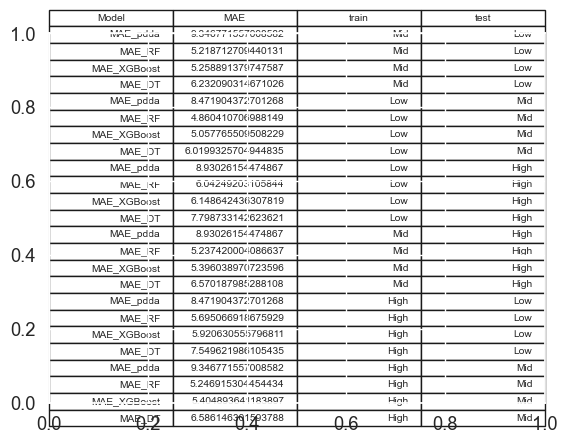

In [318]:
fig, ax = plt.subplots(1, 1)

ax.table(cellText=merged.values, colLabels=merged.keys(), loc='center')
plt.show()

In [311]:
# glue = sns.load_dataset("glue").pivot("Model", "Task", "Score")
cols = ["MAE train low test mid", "MAE train mid test low"]
def posHeatmapXY(maes, pdda_maes, figsize=(15,7)):
    '''
    Plots a heatmap given the mean euclidean distance errors of the model.
    Input:  A (3,7) numpy array containing the mean euclidean distance errors of the model trained and tested in different room combinations
    Output: Prints the heatmap
    '''
    
    training_room_names = ['Low Furniture', 'Mid Furniture']
    testing_room_names = ['RF', 'XGBoost', 'DT']

    fig, ax = plt.subplots(2,1, sharex=True, figsize=figsize, gridspec_kw={'height_ratios': [1,4]})
    cbar_ax = fig.add_axes([.91, .12, .03, .75])
    print(testing_room_names)
    # euclid_pdda = pd.DataFrame(pdda_maes, testing_room_names)
    euclid = pd.DataFrame(maes, training_room_names, testing_room_names)
    # euclid_pdda.rename(columns = {0: ''}, inplace = True)

    vmax = np.max(euclid_pdda.values)
    vmin = np.min(euclid.values)
    print(colors.LogNorm(vmin, vmax))
    # sns.heatmap(euclid_pdda.T, annot=True, annot_kws={"size": 20}, cmap="YlGnBu", cbar_ax = cbar_ax, norm=colors.LogNorm(vmin, vmax), ax=ax[0])
    sns.heatmap(euclid, annot=True, annot_kws={"size": 20}, cbar=False, vmax = vmax, vmin = vmin, cmap="YlGnBu", cbar_ax = None, norm=colors.LogNorm(vmin, vmax), ax=ax[1])

    ax[0].set_ylabel('PDDA', rotation=0, ha='right')
    sns.set(font_scale=1.2)
    
    fig.text(0.52, -0.1, 'Model', ha='center')
    fig.text(0, 0.4, 'Training Room', va='center', rotation='vertical')

    cbar_ax.set_ylabel('MEDE (m)', fontsize=14)

    ax[1].set_yticklabels(ax[1].get_yticklabels(), rotation=0) 
    ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=45, ha='center') 
    
    plt.show()

In [312]:
maes = merged[merged['Model'] != 'MAE_pdda']
maes = maes["MAE"].values
maes = maes.reshape(3,6)

In [313]:
maes

array([[5.21871271, 5.25889138, 6.23209031, 4.86041071, 5.05776551,
        6.01993257],
       [6.04249203, 6.14864244, 7.79873314, 5.23742   , 5.39603897,
        6.57018799],
       [5.69506692, 5.92063056, 7.54962199, 5.2469153 , 5.40489364,
        6.5861463 ]])

In [314]:
pdda_maes = merged[merged['Model'] == 'MAE_pdda']
pdda_maes = pdda_maes["MAE"].values
pdda_maes = pdda_maes.reshape(1,6)

In [315]:
pdda_maes.shape

(1, 6)

['RF', 'XGBoost', 'DT']


ValueError: Shape of passed values is (3, 6), indices imply (2, 3)

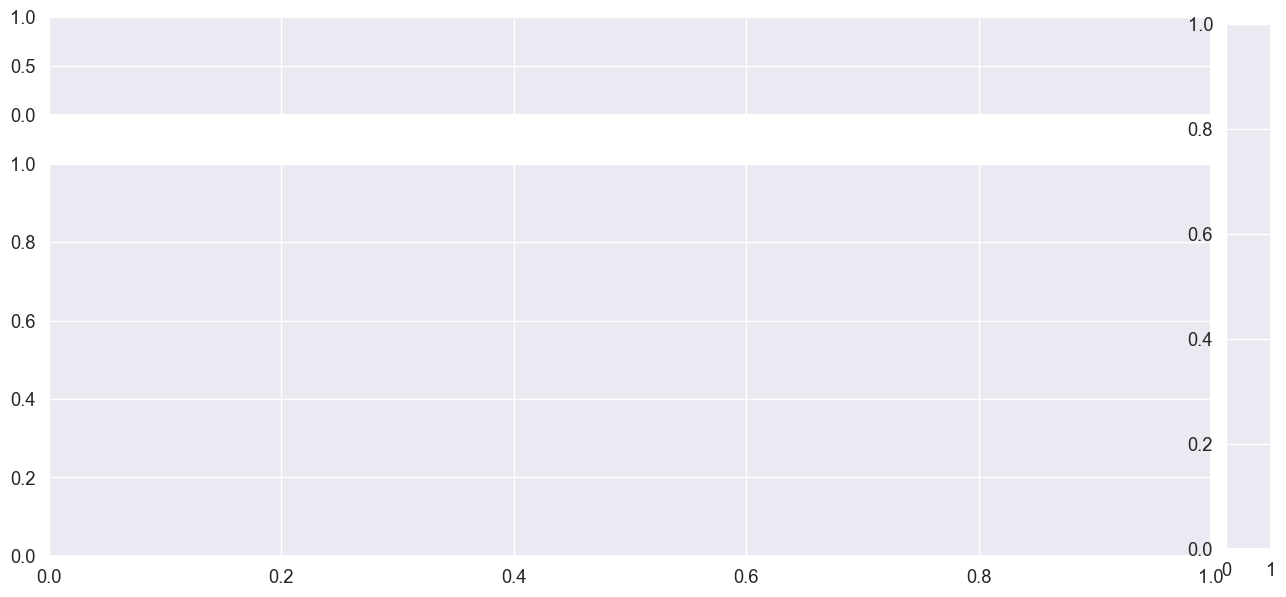

In [316]:
posHeatmapXY(maes, pdda_maes)